In [4]:
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate

# --------------------
# Load trained model
# --------------------
model = joblib.load("../api/model.joblib")

# --------------------
# Load data
# --------------------
df = pd.read_csv("../data/data.csv")

# Same preprocessing as training
df["gender"] = pd.factorize(df["gender"])[0]
df = df.drop(columns=["sno"])
df = df.dropna()

# --------------------
# Bucket age into 20-year bins
# --------------------
df["age_bin"] = pd.cut(
    df["age"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0-20", "20-40", "40-60", "60-80", "80+"]
)

# --------------------
# Features, target, sensitive attribute
# --------------------
X = df.drop(columns=["target", "age_bin"])
y = df["target"]
sensitive = df["age_bin"]

# Same split strategy as training
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X, y, sensitive,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# --------------------
# Predict using existing model
# --------------------
y_pred = model.predict(X_test)

# --------------------
# Fairness evaluation (reference-aligned)
# --------------------
metrics = {
    "accuracy": accuracy_score,
    "selection_rate": selection_rate
}

mf = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_test
)

# --------------------
# Results
# --------------------
print("Overall metrics:\n", mf.overall)
print("\nMetrics by age group:\n", mf.by_group)


Overall metrics:
 accuracy          0.864407
selection_rate    0.000000
dtype: float64

Metrics by age group:
          accuracy  selection_rate
age_bin                          
20-40    0.666667             0.0
40-60    0.868421             0.0
60-80    0.888889             0.0


Number of false negative samples: 14


/opt/conda/lib/python3.10/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


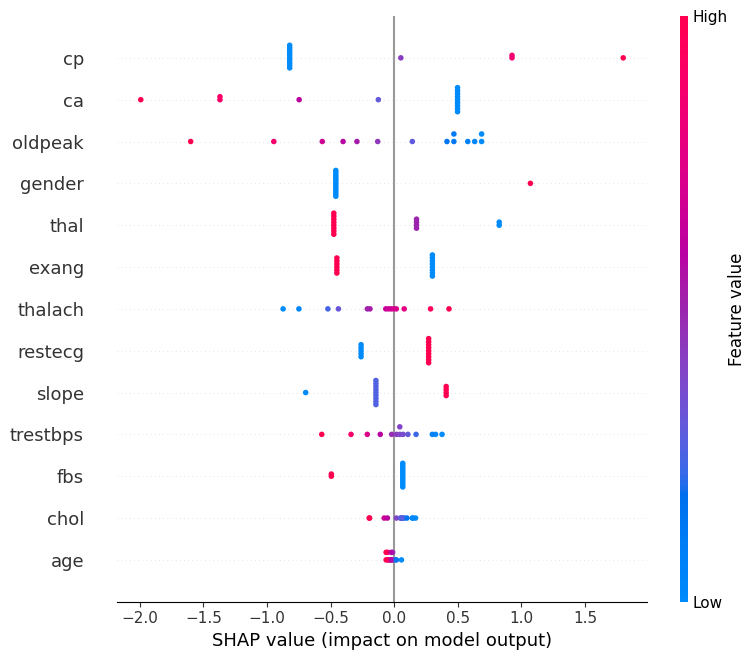

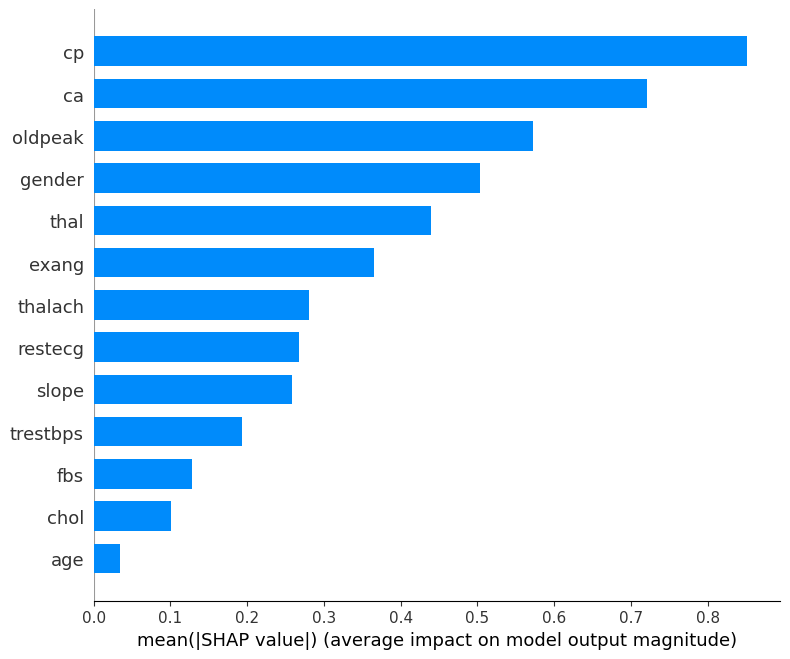

In [5]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt

# --------------------
# Predictions
# --------------------
y_pred = model.predict(X)

# --------------------
# Identify false negatives
# (actual = yes, predicted = no)
# --------------------
false_negatives_idx = (y == "yes") & (y_pred == "no")
X_fn = X[false_negatives_idx]

print(f"Number of false negative samples: {X_fn.shape[0]}")

# --------------------
# SHAP explanation (LinearExplainer)
# --------------------
explainer = shap.LinearExplainer(model, X, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_fn)

# --------------------
# Summary plots
# --------------------
shap.summary_plot(shap_values, X_fn, show=True)
shap.summary_plot(shap_values, X_fn, plot_type="bar", show=True)
